In [ ]:
# %pip install datasets
# %pip install Pillow
# %pip install tensorflow matplotlib
# %pip install 

Image dataset:
    To get the data needed for our models, I tried to make a dataset containing both real data (from existing video games or forums) and synthetic data (using environments in game engines such as Unity or Unreal engine). 
    For the real data, no complete dataset can be found on the internet for my specific needs, so I decided to work with the dataset provided by GlitchBench, but I need to alter the labelling as follows:
        Physics, Collision and Spawn Issues -> Collision Issues
        Rendering and Texture Issues -> Texture Issues
        Camera, User Interface and Lighting Issues -> Lighting Issues
        Animation and Pose Errors -> Animation Issues
        Normal Images -> No Issues were found
    
    Now, in order to balance the dataset, I need to add some synthetic data that will follow the same labelling system


Video dataset:
    

In [1]:
from datasets import load_dataset
from PIL import Image

dataset = load_dataset("glitchbench/GlitchBench")

c:\Users\liciu\anaconda3\envs\video-games-glitch-detection\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
#Split the dataset into training, validation and test sets
# training - 80%, validation - 10%, test - 10%
import numpy as np
import os



#Then we split the images into training, validation and test sets
def split_dataset(images):
    train_split = int(0.8 * len(images))
    val_split = int(0.1 * len(images))

    #print(train_split)
    #print(val_split)

    train_images = images[:train_split]
    val_images = images[train_split:train_split+val_split]
    test_images = images[train_split+val_split:]

    #print(len(train_images))
    #print(len(val_images))
    #print(len(test_images))
    return train_images, val_images, test_images


#Save the images and the labels to the disk
def save_images(images, folder):
    for i in range(len(images)):
        #print(images[i]['image'])
        image = images[i]['image']
        image.save(os.path.join("images", folder, images[i]['id'] + ".png"))


def save_labels(images, folder):
    with open(os.path.join("labels", folder + ".txt"), "w") as f:
        for image in images:
            label = image['glitch-type']
            if label.find("Collision") != -1:
                label = "Collision Issues"
            elif label.find("Texture") != -1:
                label = "Texture Issues"
            elif label.find("Lighting") != -1:
                label = "Lighting Issues"
            elif label.find("Animation") != -1:
                label = "Animation Issues"
            else:
                label = "No issue"

            f.write(image['id'] + " " + label + "\n")



if __name__ == "__main__":
    images = [dataset['validation'][i] for i in range(len(dataset['validation']))]
    #np.random.shuffle(images)
    train_images, val_images, test_images = split_dataset(images)
    print(train_images[0])
    #save_images(train_images, "train_images")
    #save_images(val_images, "validation_images")
    #save_images(test_images, "test_images")

    #save_labels(train_images, "train_labels")
    #save_labels(val_images, "validation_labels")
    #save_labels(test_images, "test_labels")

#slice_50_e4nprh-0211

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1280x720 at 0x1B0663C9DC0>, 'id': 'slice_0_jfak54-0003', 'reddit': 'jfak54', 'glitch-type': 'Physics, Collision, and Spawn', 'game': 'AC Odyssey', 'source': 'Social Media', 'description': 'secret', '__index_level_0__': 565}


After gathering the data we can continue with step 2:
    put all the data into 3 separate folders: train, validate, test with ratios: 0.8, 0.1, 0.1
    and then preprocess the training data using techniques like transfer learning, resizing, scaling, cropping, pixel mean value, normalizing

The data should be labelled as follows: 
    - take all the data given and shuffle it so that it makes the array random, than create the label files by class:
    - (1 - Collision Issues, 2 - Texture Issues, 3 - Lighting Issues, 4 - Animation Issues, 0 - No issues)

In [12]:
#Firstly we need to gather all the data from the dataset and create the folders and the labels files

#Get images from every folder and save all of them to all_images folder and create the labels file
import os
import shutil
import pandas as pd

folders = ['images', 'low-res-images', 'normal-images', 'placeholder-images', 'stretched-images', 'gathered_images']

if not os.path.exists("all_images"):
    os.makedirs("all_images")

data = []

for folder in folders:
    for root, _, files in os.walk(os.path.join("images", folder)):
        for file in files:
            label = 0
            if folder == "images":
                #search for the label in the labels file
                with open(os.path.join("labels", "labels.txt"), "r") as f:
                    new_file = file.split(".")[0]
                    for line in f:
                        if line.find(new_file) != -1:
                            initial_label = line.split(" ")[1]
                            if initial_label == "Collision":
                                label = 1
                            elif initial_label == "Texture":
                                label = 2
                            elif initial_label == "Lighting":
                                label = 3
                            elif initial_label == "Animation":
                                label = 4
                            else:
                                label = 0
                            break
            elif folder in ["low-res-images", "placeholder-images", "stretched-images"]:
                label = 2
            elif folder in ["normal-images", "gathered-images"]:
                label = 0
            
            #shutil.copy(os.path.join(root, file), os.path.join("all_images", file))
            data.append([file, label])
        
print(len(data))
#df = pd.DataFrame(data, columns=["image", "label"])
#df.to_csv("labels/all_labels.csv", index=False)

#Count the number of images in each class
df = pd.read_csv("labels/all_labels.csv")
print(df['label'].value_counts())

728
label
1    433
2    100
0     91
4     83
3     21
Name: count, dtype: int64


In [18]:
from sklearn.model_selection import train_test_split

df = pd.read_csv("labels/all_labels.csv")
train, test = train_test_split(df, test_size=0.1, stratify=df['label'], random_state=42)
train, val = train_test_split(train, test_size=0.1, stratify=train['label'], random_state=42)

train.to_csv("labels/train_labels.csv", index=False)
val.to_csv("labels/val_labels.csv", index=False)
test.to_csv("labels/test_labels.csv", index=False)

print(train['label'].value_counts())
print(val['label'].value_counts())
print(test['label'].value_counts())



label
1    350
2     81
0     74
4     67
3     17
Name: count, dtype: int64
label
1    39
2     9
0     8
4     8
3     2
Name: count, dtype: int64
label
1    44
2    10
0     9
4     8
3     2
Name: count, dtype: int64


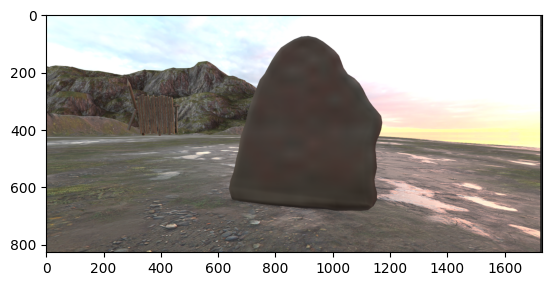

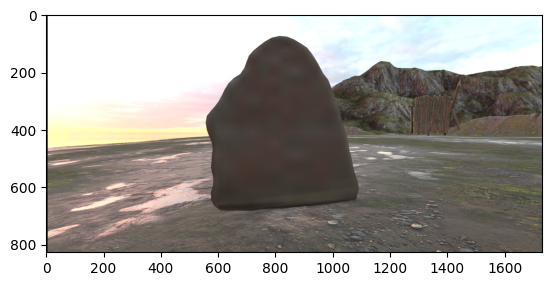

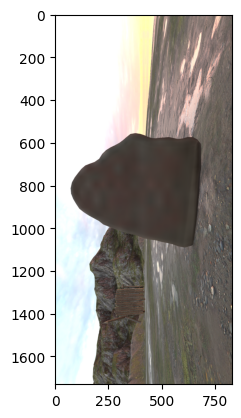

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0335539..1.1590167].


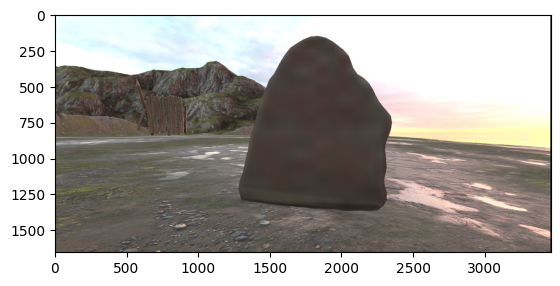

In [5]:
#plot train/TextureIsssues/low_res_image9.png
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

low_tex_img = plt.imread("./dataset/train/TextureIssues/low-res-image9.png")
plt.imshow(low_tex_img)
plt.show()

#flip the image

flipped_low_tex_img = np.fliplr(low_tex_img)
plt.imshow(flipped_low_tex_img)
plt.show()

#rotate the image

rotated_low_tex_img = np.rot90(low_tex_img)
plt.imshow(rotated_low_tex_img)
plt.show()

#zoom the image

from scipy.ndimage import zoom

#high contrast image

grayscale_img = tf.image.rgb_to_grayscale(low_tex_img)
bright = tf.image.adjust_brightness(grayscale_img, 0.5)
contrast = tf.image.adjust_contrast(bright, 2)

plt.imshow(contrast)
plt.show()
